## Import packages and data

COVID-19 data is imported from the JHU github repo

In [1]:
# !pip install pandas
import os
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
root = "./COVID-19/csse_covid_19_data/csse_covid_19_daily_reports"
all_csvs = [i for i in os.listdir(root) if i.endswith(".csv")]

Concatenating all csvs and calculate number of current infectious events

In [2]:
dfs = []
for i in all_csvs:
    df = pd.read_csv(os.path.join(root, i))
    df.fillna(0, inplace=True)
    df['Country/Region'] = df["Country/Region"].apply(lambda x: x.strip())
    df["Last Update"] = pd.to_datetime(df["Last Update"])
    dfs.append(df)

In [3]:
df = pd.concat(dfs)
df.drop_duplicates(inplace=True)
df.sort_values("Last Update", inplace=True)

In [4]:
df['Number of Infectious'] = df["Confirmed"] - df["Deaths"] - df["Recovered"]

In [5]:
df.head(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Number of Infectious
16,Jiangsu,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0
14,Hunan,Mainland China,2020-01-22 17:00:00,4.0,0.0,0.0,4.0
13,Hubei,Mainland China,2020-01-22 17:00:00,444.0,17.0,28.0,399.0
12,Hong Kong,Hong Kong,2020-01-22 17:00:00,0.0,0.0,0.0,0.0
11,Henan,Mainland China,2020-01-22 17:00:00,5.0,0.0,0.0,5.0


In [ ]:
print([(i,j) for i, j in zip(df["Province/State"], df["Country/Region"])])

## Visualize counts across time for mainland chinese provinces/states

In [6]:
from matplotlib import pyplot as plt
def plot_count_across_time(df, country, region=None):
    if region != None:
        temp_df = df[(df["Country/Region"] == country) & (df["Province/State"] == region)]
#         temp_df = temp_df.resample('D', on="Last Update").sum().reset_index()
    else:
        temp_df = df[(df["Country/Region"] == country) ]
        temp_df = temp_df.resample('D', on="Last Update").sum().reset_index()
        
        temp_df["Last Update"] = pd.to_datetime(temp_df["Last Update"])
    
#     temp_df["Number of Infectious"] = temp_df["Number of Infectious"].diff()
    temp_df.sort_values("Last Update", inplace=True)
    temp_df.plot(x="Last Update", y="Number of Infectious", kind='line', figsize=(6,4))
    plt.xticks(rotation=90)
    plt.title("{} - {}".format(country, region))

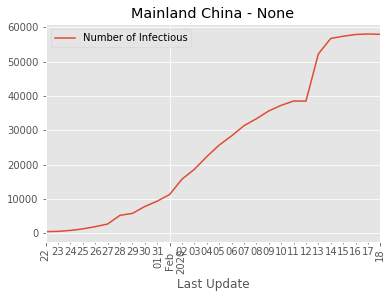

In [7]:
plot_count_across_time(df, "Mainland China")

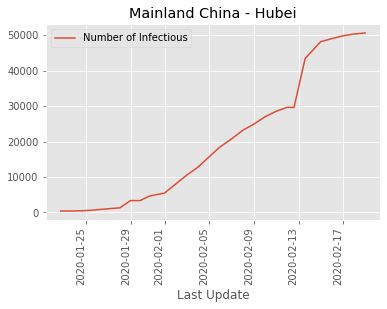

In [8]:
plot_count_across_time(df, "Mainland China", "Hubei")

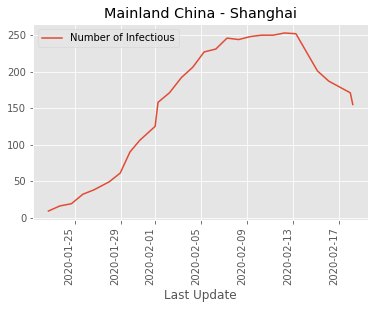

In [9]:
plot_count_across_time(df, "Mainland China", "Shanghai")

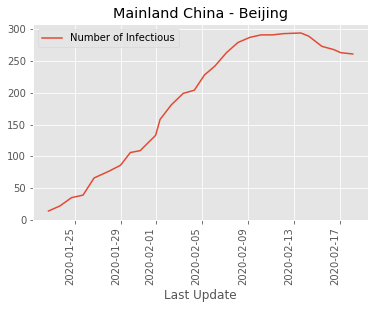

In [10]:
plot_count_across_time(df, "Mainland China", "Beijing")

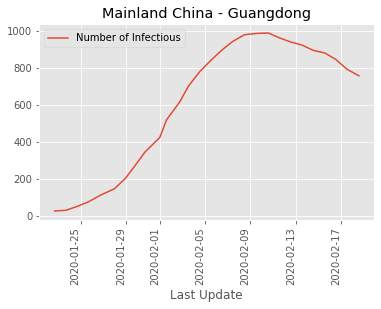

In [11]:
plot_count_across_time(df, "Mainland China", "Guangdong")

## International Cities

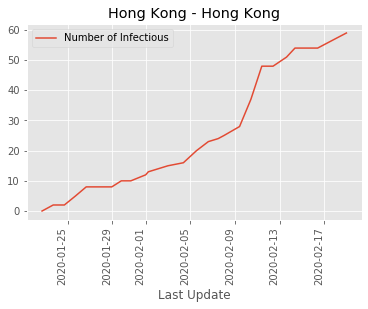

In [12]:
plot_count_across_time(df, "Hong Kong", "Hong Kong")

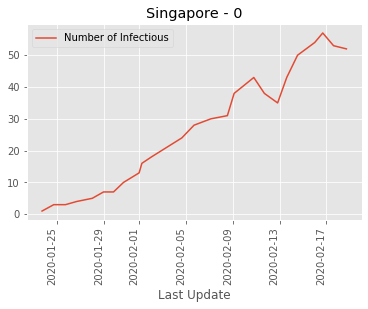

In [13]:
plot_count_across_time(df, "Singapore", 0)

## Plot with different rate for Poisson Distribution for each city
$\displaystyle\frac{e^{-\mu_i} \mu_i^{t_i}}{t_i!}$ where $\mu_i=I_{0}e^{rt_i}$

In [14]:
import numpy as np
def plot_poisson_and_data(df, country, rate, region=None):
    
    if region != None:
        temp_df = df[(df["Country/Region"] == country) & (df["Province/State"] == region)]
#         temp_df = temp_df.resample('D', on="Last Update").sum().reset_index()
    else:
        temp_df = df[(df["Country/Region"] == country) ]
#         temp_df = temp_df.resample('D', on="Last Update").sum().reset_index()
        
#         temp_df["Last Update"] = pd.to_datetime(temp_df["Last Update"])
    
#     temp_df["Number of Infectious"] = temp_df["Number of Infectious"].diff()

    temp_df.sort_values("Last Update", inplace=True)
    temp_df.reset_index(inplace=True)
    pois_val = []
    initial = temp_df["Number of Infectious"].iloc[0]
    for i in range(temp_df.shape[0]):
        pois_val.append( np.random.poisson(np.exp(i*rate)) )

    temp_df.plot(y="Number of Infectious", kind='line', figsize=(6,4))
    plt.plot(pois_val, label='Poisson w. rate {}'.format(rate))
    plt.xticks(rotation=90)
    plt.title("{} - {}".format(country, region))
    plt.legend()

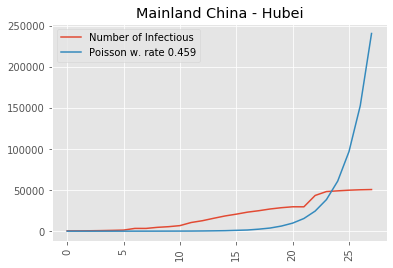

In [15]:
plot_poisson_and_data(df, "Mainland China", 0.459, "Hubei")

## Calculating R_0 

In [16]:
# finds the best param for each interval using statsmodels api, then return R_o
import statsmodels.api as sm
def calculate_R_0(df, country, region=None, interval=1):
    if region != None:
        temp_df = df[(df['Country/Region'] == country) & (df['Province/State'] == region)]
    else:
        temp_df = df[df['Country/Region'] == country]
        
#     max_idx = temp_df['Number of Infectious'].argmax()
    max_idx = 8
    temp = temp_df.iloc[:max_idx]
    res = sm.GLM(
        temp["Number of Infectious"],
        [i for i in range(temp.shape[0])], sm.families.Poisson()
    ).fit().params.values[0]
    
#     r0 = res * temp.shape[0] + 1
    r0 = res * max_idx + 1
    return res, r0, temp.iloc[-1]['Last Update']

Specify which country and region you are interested in

In [17]:
country_region = [
    ('Singapore', 0), ('Mainland China', 'Hubei'), ('Mainland China', 'Shanghai'), 
    ('Mainland China', 'Beijing'), ('Hong Kong', 'Hong Kong'), ('Taiwan', 'Taiwan'),
    ('Mainland China', 'Jilin'),
    ('Malaysia', 0)
]
r0_dict = dict()
for c in country_region:
    r, r0, last_date = calculate_R_0(df, c[0], interval=1, region=c[1])
    r0_dict["{}_{}".format(c[0], c[1])] = (r, r0, last_date)

$R_0 = rd + 1$

In [18]:
summary = pd.DataFrame.from_dict(r0_dict).T
summary.columns = ["Growth rate(r)", "R0", "Last date"]
summary

,Growth rate(r),R0,Last date
Singapore_0,0.348976,3.79181,2020-01-30 16:00:00
Mainland China_Hubei,1.24725,10.978,2020-01-29 19:30:00
Mainland China_Shanghai,0.693661,6.54928,2020-01-29 19:30:00
Mainland China_Beijing,0.743424,6.94739,2020-01-29 19:30:00
Hong Kong_Hong Kong,0.368663,3.9493,2020-01-29 19:30:00
Taiwan_Taiwan,0.322336,3.57869,2020-01-29 19:30:00
Mainland China_Jilin,0.337671,3.70136,2020-01-29 19:30:00
Malaysia_0,0.33961,3.71688,2020-01-31 08:15:00
